# 꽃 이미지 분류
- 참고 : https://www.tensorflow.org/tutorials/images/classification
- preprocessing.image_dataset_from_directory를 사용하여 데이터를 로드
- 디스크에서 데이터세트를 효율적으로 로드
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용

## 머신러닝 워크플로우

- 데이터 검사 및 이해하기
- 입력 파이프라인 빌드하기
- 모델 빌드하기
- 모델 훈련하기
- 모델 테스트하기
- 모델을 개선하고 프로세스 반복하기

## 라이브러리 가져오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터셋 다운로드 및 탐색하기
약 3,700장의 꽃 사진 데이터세트를 사용
데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 존재
<pre>
flower_photo/  
  daisy/  
  dandelion/  
  roses/  
  sunflowers/  
  tulips/  
</pre>

In [2]:
# 데이터 다운로드
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 25s 0us/step


In [3]:
# 데이터 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


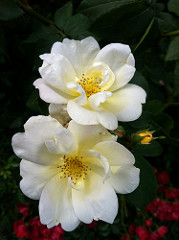

In [20]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

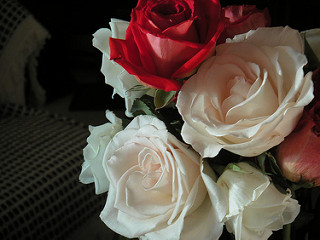

In [21]:
PIL.Image.open(str(roses[1]))

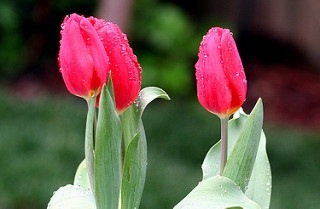

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

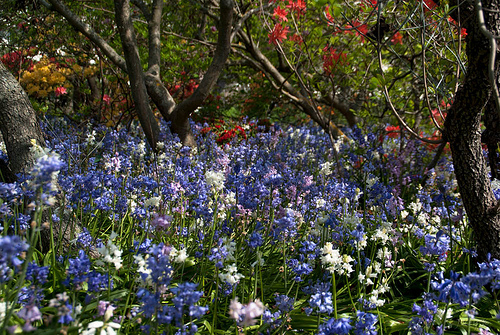

In [22]:
PIL.Image.open(str(tulips[1]))

# Keras.preprocessing을 사용한 로드하기

## 데이터세트 만들기

In [15]:
# 로더에 대한 몇가지 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [16]:
# 검증 데이터 분할
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## class_names 속성

In [18]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화

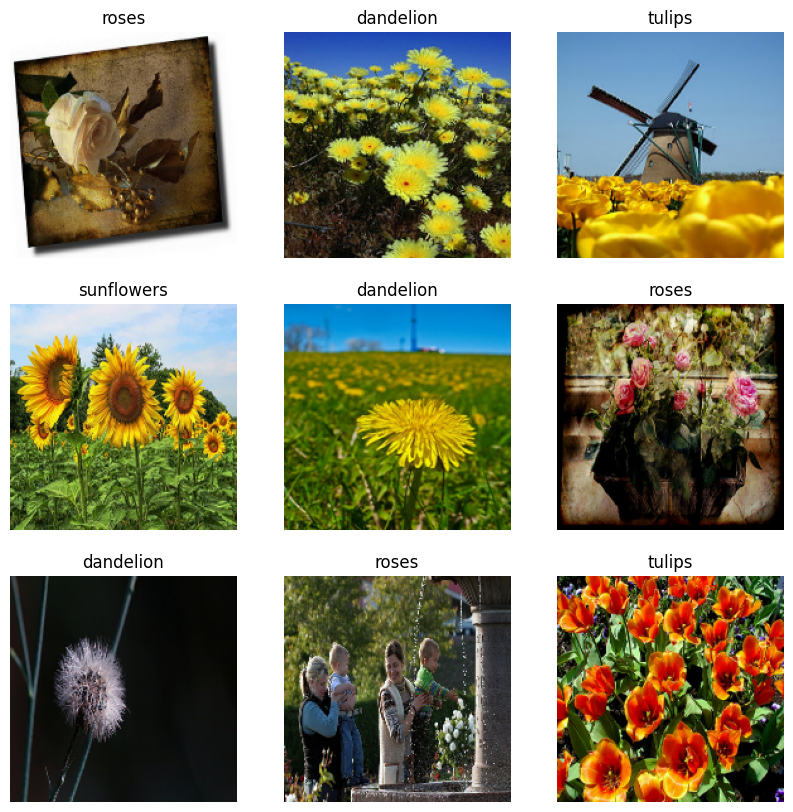

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 성능을 높이도록 데이터세트 구성하기

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화 하기

In [25]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06013127 0.9978214


# 모델 만들기

In [27]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 6s 23ms/step - loss: 1.2376 - accuracy: 0.4751 - val_loss: 1.0936 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 2s 16ms/step - loss: 0.9678 - accuracy: 0.6284 - val_loss: 0.9528 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 1s 16ms/step - loss: 0.7838 - accuracy: 0.7040 - val_loss: 0.9053 - val_accuracy: 0.6485
Epoch 4/10
92/92 [==============================] - 2s 17ms/step - loss: 0.5773 - accuracy: 0.7800 - val_loss: 0.8885 - val_accuracy: 0.6703
Epoch 5/10
92/92 [==============================] - 1s 16ms/step - loss: 0.3726 - accuracy: 0.8651 - val_loss: 0.9412 - val_accuracy: 0.6608
Epoch 6/10
92/92 [==============================] - 2s 17ms/step - loss: 0.2162 - accuracy: 0.9329 - val_loss: 1.2572 - val_accuracy: 0.6240
Epoch 7/10
92/92 [==============================] - 2s 16ms/step - loss: 0.1192 - accuracy: 0.9680 - val_loss: 1.2569 - val_accuracy: 0.6512
Epoch 8/10
92

# 훈련 결과 시각화하기

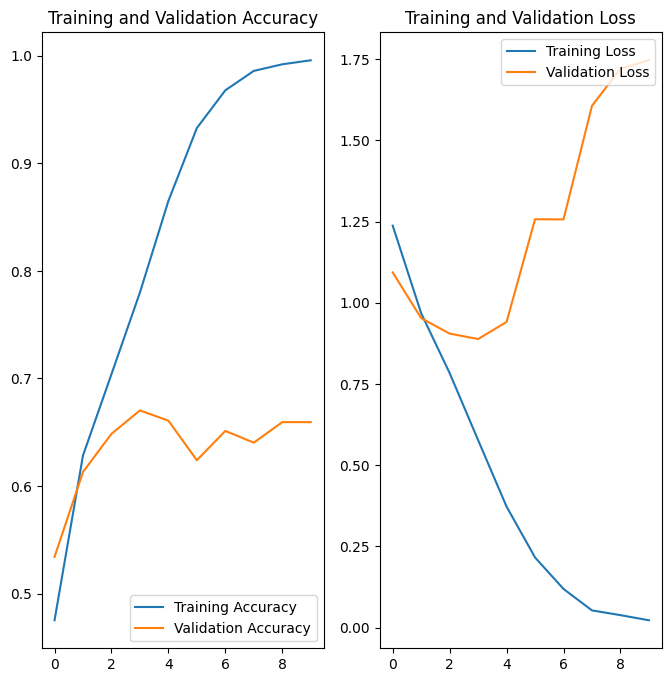

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 데이터 증강

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

- 동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강된 예제가 어떻게 보이는지 시각화

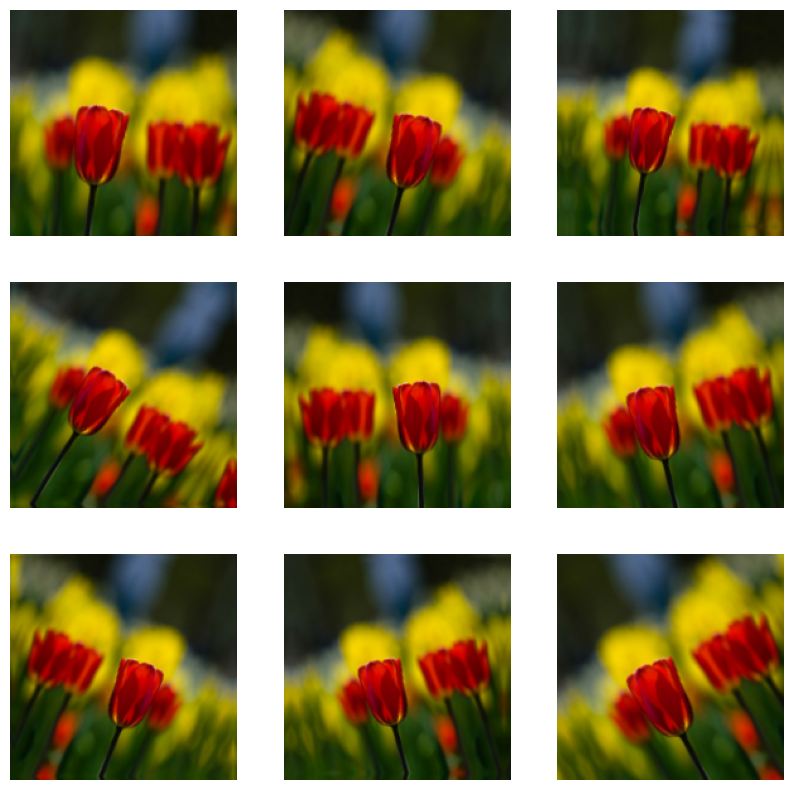

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(3):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 드롭 아웃

In [36]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # from_logits=True : 
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 3s 26ms/step - loss: 1.3327 - accuracy: 0.4407 - val_loss: 1.1469 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 2s 27ms/step - loss: 1.0522 - accuracy: 0.5889 - val_loss: 0.9953 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 2s 25ms/step - loss: 0.9422 - accuracy: 0.6281 - val_loss: 0.9227 - val_accuracy: 0.6376
Epoch 4/15
92/92 [==============================] - 2s 27ms/step - loss: 0.8615 - accuracy: 0.6696 - val_loss: 0.8379 - val_accuracy: 0.6744
Epoch 5/15
92/92 [==============================] - 2s 25ms/step - loss: 0.8008 - accuracy: 0.6873 - val_loss: 0.7899 - val_accuracy: 0.6907
Epoch 6/15
92/92 [==============================] - 2s 25ms/step - loss: 0.7642 - accuracy: 0.7037 - val_loss: 0.8001 - val_accuracy: 0.6935
Epoch 7/15
92/92 [==============================] - 2s 26ms/step - loss: 0.7343 - accuracy: 0.7098 - val_loss: 0.7649 - val_accuracy: 0.7030
Epoch 8/15
92

# 훈련 결과 시각화 하기

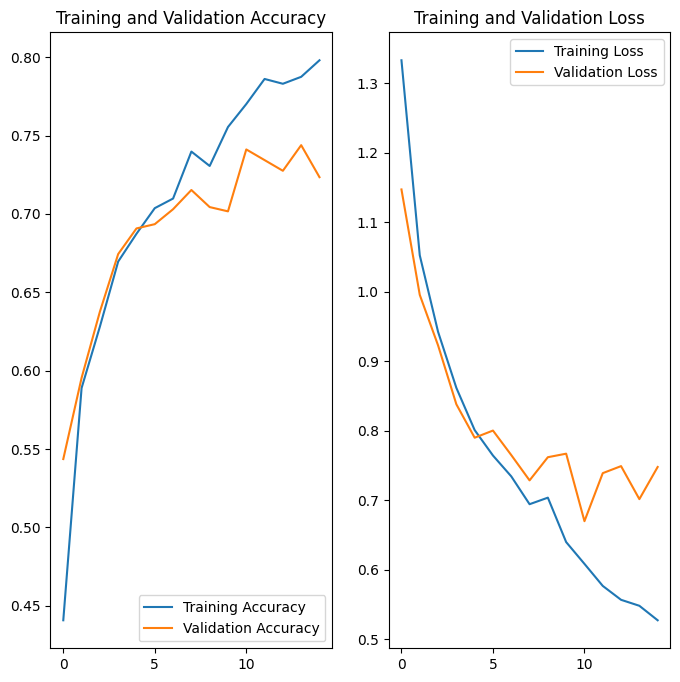

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 새로운 데이터로 예측하기

### 테스트1 : sunflower

In [43]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

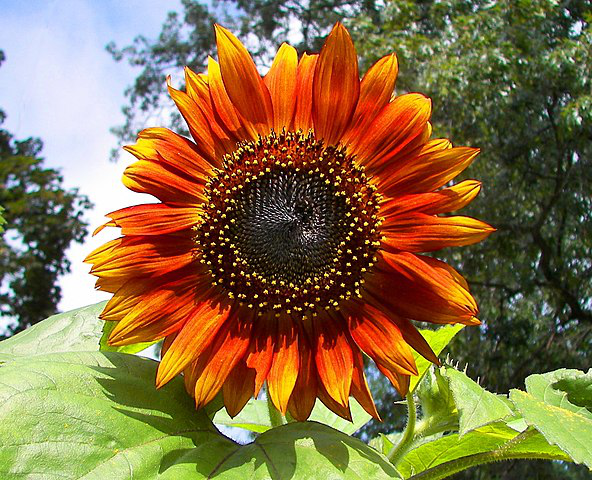

In [47]:
PIL.Image.open(sunflower_path)

In [49]:
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

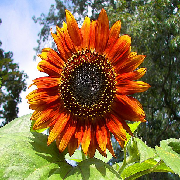

In [51]:
img

In [52]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to sunflowers with a 97.95 percent confidence.


### 테스트2 : rose

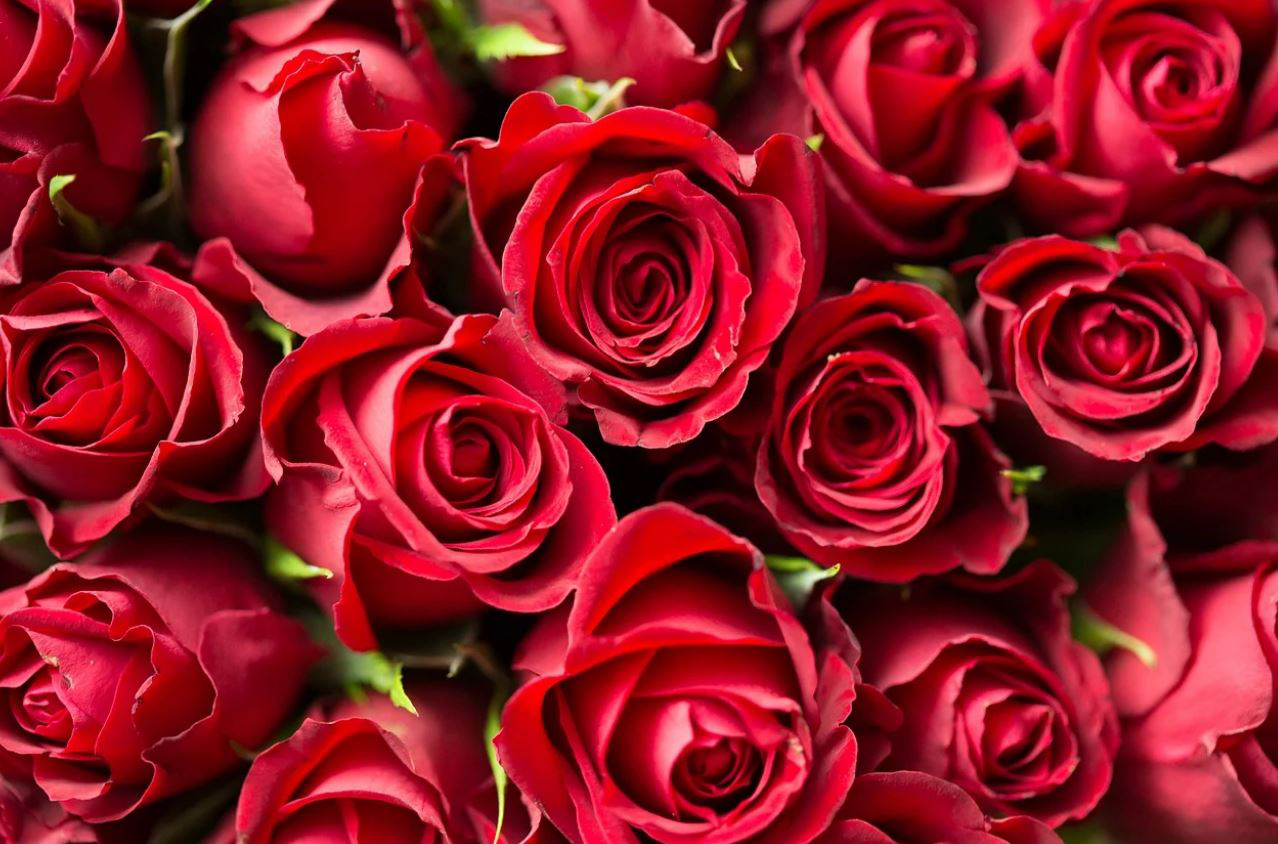

In [59]:
# https://helpful.kr/wp-content/uploads/2020/07/%EB%B9%A8%EA%B0%84.jpg

rose_url = "https://helpful.kr/wp-content/uploads/2020/07/%EB%B9%A8%EA%B0%84.jpg"
rose_path = tf.keras.utils.get_file('red_rose', origin=rose_url)
PIL.Image.open(rose_path)

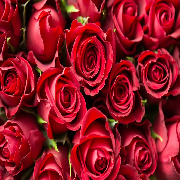

In [61]:
img = keras.preprocessing.image.load_img(
    rose_path, target_size=(img_height, img_width)
)
img

In [62]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to roses with a 100.00 percent confidence.
